In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4, max_train_size=60, test_size=18) # Train size is 5 years

# Prepare data
## Seperate development and production dataset

In [2]:
# ALL_DATA = pd.read_csv("../Data/kitCapstoneJan24_data.csv", delimiter=";")
# TARGET_COL_NAME = "sales_actuals_monthly__orderintake"
# TEST_INDEX = 258
# TEST_PERIOD = 18
# ALL_DATA

In [3]:
DATA_START = 60
TEST_INDEX = 258 - DATA_START
TEST_PERIOD = 18
TARGET_COL_NAME = "sales_actuals_monthly__vehiclegroup01__orderintake"

PATH_RUN2_DATA = r"../output_data\run2_run_countryA_all_values\run_Country A_all_2337_NaN_fillup.csv"
PATH_RUN2_F_IMPORTANCE = r"../output_data\run2_run_countryA_all_values\run_Country A_all_2349value_importance_list.csv"

PATH_RUN3_DATA = r"../output_data/run3_run_countryA_vehicle01_all_values/run_Country A_all_2351_NaN_fillup.csv"
PATH_RUN3_F_IMPORTANCE = r"../output_data/run3_run_countryA_vehicle01_all_values/run_Country A_all_2352value_importance_list.csv"

In [4]:
def get_data_sources(path_data, path_f_importance, num_features):

    value_importance = pd.read_csv(path_f_importance)
    data = pd.read_csv(path_data)

    val_imp = value_importance["Feature"].iloc[:num_features].to_list()
    train_data = data[val_imp].copy()

    train_data[TARGET_COL_NAME] =  data[TARGET_COL_NAME].copy()
    
    print(val_imp)

    return train_data

In [5]:
# def get_data(df, veh_group, country):
#     data = df.loc[df["countryname"] == country, :].filter(regex=veh_group)
#     data.columns = [col.replace(veh_group + '__', '') for col in data.columns]
#     data.reset_index(inplace=True, drop=True)
#     data = data.fillna(data.mean()) # Filling with MEAN VALUE!!!!!!! NEED to fix
#     return data

# data = get_data(ALL_DATA, "vehiclegroup01", "Country A")

def get_data(data):
    data_cut = data.iloc[DATA_START:, :]
    data_cut.reset_index(inplace=True, drop=True)
    dev_set = data_cut.iloc[:TEST_INDEX, :]
    prod_set = data_cut.iloc[:TEST_INDEX + TEST_PERIOD, :] # include features of predicting period (month 259 -> 276)

    print(dev_set.shape)
    print(prod_set.shape)

    return dev_set, prod_set

data = get_data_sources(PATH_RUN3_DATA, PATH_RUN3_F_IMPORTANCE, num_features=35)
dev_set, prod_set = get_data(data)

['leads__vehiclegroup01__won_meanbymonth', 'customer_vehicle_relationships__vehiclegroup01__active_cars', 'global_economy__total_revenue_of_gdp_general_government__percentage', 'sales_actuals_monthly__vehiclegroup01__retail', 'registrations__buildtype_pickup_meanbymonth', 'global_economy__industrial_production_index__index', 'global_economy__wholesale_producer_price_index_year_on_year_percent_change__percent_change_year_ago', 'leasing_contracts__vehiclegroup01__end', 'month_normalized', 'quota__vehiclegroup01__aq_medianbymonth', 'global_economy__deflator_fixed_investment_private_non_residential_euro__index', 'global_economy__bop_portfolio_investment_asset_debit_capital_outflow_euro__euro', 'registrations__vwm_premium_land_rover_meanbymonth', 'month', 'global_economy__growth_rate_population_urban__percentage', 'global_economy__interest_rate_long_term__percentage', 'global_economy__exchange_rate_lcu_per_us_period_average__euro', 'leads__vehiclegroup01__first_touch_point_meanbymonth', 'cu

# Traing and evaluate model
**Goal: Find the best model**

In [6]:
# Split the development set as "blocks of data" to evaluate the performance of the model
data_cv = {}
for i, (train_index, val_index) in enumerate(tscv.split(dev_set)):
    print(f"Train range {train_index[0]} - {train_index[-1]}, val range {val_index[0]} - {val_index[-1]}")
    data_cv[i] = {
        "train": data.iloc[train_index, :], 
        "val": data.iloc[val_index, :]
    }

Train range 66 - 125, val range 126 - 143
Train range 84 - 143, val range 144 - 161
Train range 102 - 161, val range 162 - 179
Train range 120 - 179, val range 180 - 197


## Define model

In [7]:
from abc import ABC, abstractmethod
from typing import List

class Model(ABC):
    @abstractmethod
    def __init__(self, data_block) -> None:
        """
            data_block: Dictionary of both train and test DataFrame
        """
        self.train_data, self.val_data = data_block["train"], data_block["val"]
        self.y_train = self.train_data.loc[:, TARGET_COL_NAME]
        self.y_val = self.val_data.loc[:, TARGET_COL_NAME]

    @abstractmethod
    def train(self) -> None:
        ...

    @abstractmethod
    def predict(self) -> List[float]:
        ...

    def run_eval(self, verbose=True) -> float:
        print("Training...")
        self.train()

        if self.y_val.isna().any().any():
            raise RuntimeError("No label data to evaluate.")

        print("\nEvaluating...")
        y_true = self.y_val.tolist()
        y_pred = self.predict()
        mape = mean_absolute_percentage_error(y_true, y_pred)

        if verbose:
            plt.figure(figsize=(15,6))
            x_ticks = range(TEST_INDEX, TEST_INDEX+TEST_PERIOD)
            plt.plot(x_ticks, y_true, color="black", label="Truth")
            plt.plot(x_ticks, y_pred, color="red", linestyle="--", label="Predict")
            plt.xticks(x_ticks)
            plt.legend()
            plt.xlabel("Month")
            plt.ylabel("Order intake")
            plt.title(f"MAPE = {mape:.4f}")
            plt.show()
            
        return mape

### ARIMAX

In [8]:
import pmdarima as pm

class SARIMAXModel(Model):
    def __init__(self, data_block, exo=True, predict_periods=TEST_PERIOD):
        super().__init__(data_block)

        self.exogenous_data_train = None
        self.exogenous_data_val = None
        if exo:
            self.exogenous_data_train = self.train_data.drop(TARGET_COL_NAME, axis=1)
            self.exogenous_data_val = self.val_data.drop(TARGET_COL_NAME, axis=1)

        self.model : pm.arima.ARIMA = None
        self.predict_periods = predict_periods

    def train(self):
        # https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
        # Find the best model using stepwise algorithm outlined in Hyndman and Khandakar (2008)
        self.sarima = pm.auto_arima(y=self.y_train, # target
                                    X=self.exogenous_data_train, # data
                                    start_p=0, max_p=5,
                                    start_q=0, max_q=5, # maximum p and q
                                    start_P=0, max_P=5,
                                    start_Q=0, max_Q=5, 
                                    d=None,              # usual differencing
                                    D=None,              # seasonal differencing
                                    seasonal=True,   # Seasonality
                                    m=12,              # frequency of series
                                    test='adf',       # use adftest to find optimal 'd'
                                    trace=True,
                                    error_action='ignore',  
                                    suppress_warnings=True,
                                    scoring='mse', # mae/mse
                                    stepwise=True)

    def predict(self):
        y_predict = self.sarima.predict(n_periods=self.predict_periods, X=self.exogenous_data_val).tolist()
        return y_predict

# SARIMAX_model = SARIMAXModel(data_cv[0], exo=False)
# SARIMAX_model.run_eval()

### XGBoost

In [9]:
import xgboost

class XGBoostModel(Model):

    x_train = []
    y_train = []

    def __init__(self, data_block):
        super().__init__(data_block)
        self.preprocessing()
        self.model = xgboost.XGBRegressor(use_label_encoder=False, eval_metric="mape")

    def preprocessing(self):
        """Main idea: Use past input data to predict future target value
            For target value:
                - Val: No change
                - Train: Don't use the first {TEST_PERIOD} months of target train
            For input data:
                - Train: Don't use the last {TEST_PERIOD} months of input data train
                - Val: Use the last {TEST_PERIOD} months of input data train
        """
        print("\nPreprocessing data...")
        self.y_train = self.y_train.iloc[TEST_PERIOD:]
        self.X_train = self.train_data.drop(TARGET_COL_NAME, axis=1).iloc[:-TEST_PERIOD, :]
        self.X_val = self.train_data.drop(TARGET_COL_NAME, axis=1).iloc[-TEST_PERIOD:, :]

    def train(self):
        tscv = TimeSeriesSplit(n_splits=10)
        for _, (train_index, val_index) in enumerate(tscv.split(self.X_train)):
            train_fold = self.X_train.iloc[train_index, :]
            test_fold = self.y_train.iloc[train_index]
            self.model.fit(train_fold, test_fold)

    def predict(self):
        prediction = self.model.predict(self.X_val).tolist()
        return prediction
    
# XGBoost_model = XGBoostModel(data_cv[0])
# XGBoost_model.run_eval()

### Prophet

In [10]:
from prophet import Prophet

class ProphetModel(Model):
    def __init__(self, data_block, predict_periods=TEST_PERIOD) -> None:
        super().__init__(data_block)
        self.preprocessing()
        self.model = Prophet(yearly_seasonality=True)
        self.predict_periods = predict_periods

    def preprocessing(self):
        """Expect to have at least 2 columns 'ds' (YYYY-MM-DD) and 'y'
            https://facebook.github.io/prophet/docs/quick_start.html#python-api    
        """
        print("\nPreprocessing data...")
        self.y_train = self.y_train.reset_index(drop=True)
        self.y_train = pd.DataFrame({'ds': range(len(self.y_train)), 'y': self.y_train.values})
        start_date = '2000-01-01'  # Adjust this date to your needs
        self.y_train['ds'] = pd.to_datetime(self.y_train['ds'].apply(lambda x: pd.DateOffset(months=x) + pd.Timestamp(start_date)))

    def train(self):
        self.model.fit(self.y_train) 

    def predict(self):
        future = self.model.make_future_dataframe(periods=self.predict_periods, freq = "MS")
        forecast = self.model.predict(future)
        predict = forecast.loc[len(self.y_train):, 'yhat'].tolist()
        return predict

# prophet_model = ProphetModel(data_cv[0])
# prophet_model.run_eval()

Importing plotly failed. Interactive plots will not work.


# Pipeline

In [11]:
# model_list = {
#     "arima": SARIMAXModel,
#     "prophet": ProphetModel,
#     "xgboost": XGBoostModel,
# }

# model_perf = {}
# for name, model in model_list.items():
#     model_perf[name] = []
#     for data in data_cv.values():
#         if name == "arima":
#             result = model(data, exo=False).run_eval(verbose=False)
#         else:
#             result = model(data).run_eval(verbose=False)

#         model_perf[name].append(result)

In [12]:
# # Visualize result
# #del model_perf["arima"]
# models = list(model_perf.keys())
# perf = list(model_perf.values())

# # Number of data blocks
# num_cv = len(perf[0])

# # Width of each bar
# bar_width = 0.2

# # Position of each bar on X-axis
# x = range(num_cv)

# # Plotting each cluster
# plt.figure(figsize=(10,6))
# for i, name in enumerate(models):
#     plt.bar([pos + i * bar_width for pos in x], perf[i], bar_width, label=name)

# # Adding labels and title
# plt.xlabel('CV')
# plt.ylabel('MAPE')
# plt.title('Compare MAPE between models')
# plt.xticks([pos + (len(models) - 1) * bar_width / 2 for pos in x], range(1, num_cv + 1))
# plt.legend()

# # Show plot
# plt.show()

In [22]:
val_dev_set = dev_set.iloc[-TEST_PERIOD:, :]
train_dev_set = dev_set.iloc[:-TEST_PERIOD, :]
print("val 18 rows", TARGET_COL_NAME in val_dev_set.columns)
val_dev_set.tail()

val 18 rows True


,leads__vehiclegroup01__won_meanbymonth,customer_vehicle_relationships__vehiclegroup01__active_cars,global_economy__total_revenue_of_gdp_general_government__percentage,sales_actuals_monthly__vehiclegroup01__retail,registrations__buildtype_pickup_meanbymonth,global_economy__industrial_production_index__index,global_economy__wholesale_producer_price_index_year_on_year_percent_change__percent_change_year_ago,leasing_contracts__vehiclegroup01__end,month_normalized,quota__vehiclegroup01__aq_medianbymonth,...,global_economy__bop_current_account_balance_euro__euro,global_economy__private_consumption_deflator_year_on_year_percent_change__percent_change_year_ago,global_economy__growth_rate_real_retail_sales_index_lcu_year_on_year_percent_change__percent_change_year_ago,registrations__vwm_luxus_aston_martin_meanbymonth,global_economy__bop_portfolio_investment_liability_credit_capital_inflow_euro__euro,global_economy__tax_rate_personal_income_taxes__percentage,global_economy__nominal_effective_trade_weighted_exchange_rate_nominal_value_of_lcu__index,global_economy__growth_rate_nominal_effective_exchange_rate__percentage,premises__vehiclegroup01__in_sales_meanbymonth,sales_actuals_monthly__vehiclegroup01__orderintake
193,757.0,673.0,47.020867,247.0,1525.0,96.232562,1.906578,319.0,2,238.0,...,278.119179,1.905445,-3.475371,29.0,146.861713,19.057471,110.110663,3.450132,472.0,531.0
194,955.0,932.0,47.020867,553.0,1906.0,97.836438,3.650336,592.0,3,393.0,...,278.119179,1.905445,6.980955,76.0,146.861713,19.057471,110.110663,3.450132,472.0,621.0
195,794.0,798.0,46.937515,450.0,1755.0,97.635954,5.222437,615.0,4,462.0,...,281.659540,1.752837,6.484508,33.0,-35.448411,19.012333,110.156598,1.754713,472.0,451.0
196,673.0,721.0,46.937515,735.0,1953.0,96.533289,7.184466,693.0,5,503.0,...,281.659540,1.752837,-0.711955,38.0,-35.448411,19.012333,110.156598,1.754713,472.0,420.0
197,853.0,871.0,46.937515,475.0,2030.0,95.731351,8.543689,831.0,6,451.0,...,281.659540,1.752837,5.439861,37.0,-35.448411,19.012333,110.156598,1.754713,639.0,544.0


In [23]:
print("180 rows train", TARGET_COL_NAME in train_dev_set.columns)
train_dev_set.tail()

180 rows train True


,leads__vehiclegroup01__won_meanbymonth,customer_vehicle_relationships__vehiclegroup01__active_cars,global_economy__total_revenue_of_gdp_general_government__percentage,sales_actuals_monthly__vehiclegroup01__retail,registrations__buildtype_pickup_meanbymonth,global_economy__industrial_production_index__index,global_economy__wholesale_producer_price_index_year_on_year_percent_change__percent_change_year_ago,leasing_contracts__vehiclegroup01__end,month_normalized,quota__vehiclegroup01__aq_medianbymonth,...,global_economy__bop_current_account_balance_euro__euro,global_economy__private_consumption_deflator_year_on_year_percent_change__percent_change_year_ago,global_economy__growth_rate_real_retail_sales_index_lcu_year_on_year_percent_change__percent_change_year_ago,registrations__vwm_luxus_aston_martin_meanbymonth,global_economy__bop_portfolio_investment_liability_credit_capital_inflow_euro__euro,global_economy__tax_rate_personal_income_taxes__percentage,global_economy__nominal_effective_trade_weighted_exchange_rate_nominal_value_of_lcu__index,global_economy__growth_rate_nominal_effective_exchange_rate__percentage,premises__vehiclegroup01__in_sales_meanbymonth,sales_actuals_monthly__vehiclegroup01__orderintake
175,540.0,635.0,46.664641,502.0,1560.0,101.344917,0.287908,440.0,8,200.0,...,283.231190,1.342530,3.101887,44.0,73.623255,19.546312,106.513435,-0.867879,361.0,260.0
176,482.0,597.0,46.664641,510.0,1013.0,100.542979,-0.095511,493.0,9,479.0,...,283.231190,1.342530,3.332561,24.0,73.623255,19.546312,106.513435,-0.867879,417.0,214.0
177,468.0,561.0,46.038242,483.0,993.0,100.041768,-0.571429,520.0,10,603.0,...,245.663851,1.230414,1.559282,30.0,-94.861750,19.596632,106.180997,-0.888158,417.0,202.0
178,464.0,513.0,46.038242,419.0,1158.0,100.242252,-0.666032,459.0,11,400.0,...,245.663851,1.230414,2.452104,44.0,-94.861750,19.596632,106.180997,-0.888158,278.0,256.0
179,496.0,458.0,46.038242,329.0,1558.0,98.036923,-0.191022,452.0,0,225.0,...,245.663851,1.230414,2.663870,60.0,-94.861750,19.596632,106.180997,-0.888158,278.0,219.0


In [15]:
dev_set_meta = {"train":train_dev_set, "val":val_dev_set}

In [21]:
from sklearn.ensemble import RandomForestRegressor

class MetaModel(Model):
    def __init__(self, data_block, predict_periods=TEST_PERIOD) -> None:
        super().__init__(data_block)
        self.data_block = data_block
        print(self.data_block["train"].tail())
        self.predict_periods = predict_periods
        self.preprocessing()
        # self.metamodel = xgboost.XGBRegressor(use_label_encoder=False, eval_metric="mape")
        self.metamodel = RandomForestRegressor()

    def preprocessing(self):
        """
        Split the train data into half: submodel and metadata
        """
        self.half_data_index = int(len(self.train_data)/2)
        self.meta_half_data_index = round(self.half_data_index/self.predict_periods) * self.predict_periods

        # 2nd half
        self.y_metadata = self.y_train.iloc[-self.meta_half_data_index:]

    def train_predict_submodel(self, input_data) -> pd.DataFrame:
        """
            Train all submodels and make predictions
        """
        self.prophet_model = ProphetModel(input_data)
        self.arimax_model = SARIMAXModel(input_data, exo=False)
        self.xgboost_model = XGBoostModel(input_data)

        self.prophet_model.train()
        self.arimax_model.train()
        self.xgboost_model.train()
            
        prophet_pred = self.prophet_model.predict()
        arimax_pred = self.arimax_model.predict()
        xgboost_pred = self.xgboost_model.predict()

        submodel_predictions = pd.DataFrame({
            "prophet_pred": prophet_pred,
            "arimax_pred": arimax_pred,
            "xgboost_pred": xgboost_pred
        })

        return submodel_predictions

    def train(self):
        # Train sub-models and use prediction of sub-models for meta model
        list_submodel_predictions = []
        submodel_data_index = self.half_data_index

        # Sequentially adding more data to train submodels until we make prediction for the whole second half of the data
        while submodel_data_index < len(self.y_train):
            train_submodel_data = self.train_data.iloc[:submodel_data_index, :]
            val_submodel_data = self.train_data.iloc[submodel_data_index:submodel_data_index+self.predict_periods, :]
            data_block_submodel = {
                "train": train_submodel_data,
                "val": val_submodel_data
            }

            submodel_predictions_df = self.train_predict_submodel(data_block_submodel)
            list_submodel_predictions.append(submodel_predictions_df)
            submodel_data_index += self.predict_periods

        # Train meta model
        # Create the dataset to train the meta model
        metadata_input = pd.concat(list_submodel_predictions, axis=0, sort=False)
        target = self.y_metadata

        self.metamodel.fit(metadata_input, target)

        # score of 4 models
        # list_submodel_predictions
        # meta_score = mean_absolute_percentage_error(target.tolist(), submodel_pred)
        # self.metamodel.score()

    def predict(self, submodel_pred=False):
        submodel_predictions_df = self.train_predict_submodel(self.data_block)
        final_prediction = self.metamodel.predict(submodel_predictions_df).tolist()
        if submodel_pred:
            return final_prediction, submodel_predictions_df
        else:
            return final_prediction
    
    def run_eval(self, verbose=True) -> float:
        print("Training metamodel...")
        self.train()

        if self.y_val.isna().any().any():
            raise RuntimeError("No label data to evaluate.")

        print("\nEvaluating...")
        y_true = self.y_val.tolist()
        y_pred, submodel_predictions_df = self.predict(submodel_pred=True)
        mape = mean_absolute_percentage_error(y_true, y_pred)

        if verbose:
            plt.figure(figsize=(15,6))
            x_ticks = range(TEST_INDEX, TEST_INDEX+TEST_PERIOD)
            plt.plot(x_ticks, y_true, color="black", label="Truth")
            plt.plot(x_ticks, y_pred, color="red", linestyle="--", label="Meta predict")
            for method in submodel_predictions_df.columns:
                submodel_pred = submodel_predictions_df[method].tolist()
                submodel_mape = mean_absolute_percentage_error(y_true, submodel_pred)
                plt.plot(x_ticks, submodel_pred, linestyle=":", label=f"{method}: {submodel_mape:.2f}")
            
            plt.xticks(x_ticks)
            plt.legend()
            plt.xlabel("Month")
            plt.ylabel("Order intake")
            plt.title(f"MAPE = {mape:.4f}")
            plt.show() 

meta_model = MetaModel(dev_set_meta)
meta_model.run_eval()

16:12:17 - cmdstanpy - INFO - Chain [1] start processing


     leads__vehiclegroup01__won_meanbymonth  \
175                                   540.0   
176                                   482.0   
177                                   468.0   
178                                   464.0   
179                                   496.0   

     customer_vehicle_relationships__vehiclegroup01__active_cars  \
175                                              635.0             
176                                              597.0             
177                                              561.0             
178                                              513.0             
179                                              458.0             

     global_economy__total_revenue_of_gdp_general_government__percentage  \
175                                          46.664641                     
176                                          46.664641                     
177                                          46.038242                     
178 

16:12:18 - cmdstanpy - INFO - Chain [1] done processing


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1057.127, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1037.807, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1040.786, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1283.064, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1040.190, Time=0.00 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1038.095, Time=0.24 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1039.197, Time=0.15 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1038.997, Time=0.08 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=1039.441, Time=0.24 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1048.968, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1039.900, Time=0.07 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=1039.823, Time=0.11 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1039.070, Time=0.09 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=1041.764, Time=0.17 sec
 ARIMA(1,0,0)(1,0,0

16:12:21 - cmdstanpy - INFO - Chain [1] start processing
16:12:21 - cmdstanpy - INFO - Chain [1] done processing



Preprocessing data...

Preprocessing data...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1257.114, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1233.358, Time=0.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1237.181, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1536.558, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1237.488, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1233.414, Time=0.31 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1234.448, Time=0.17 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1234.956, Time=0.10 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=1235.062, Time=0.34 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1247.127, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1235.316, Time=0.13 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=1235.441, Time=0.12 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1235.025, Time=0.09 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : A

KeyboardInterrupt: 

In [19]:
train_prod_set = prod_set.iloc[-TEST_PERIOD:, :]
val_prod_set = prod_set.iloc[:-TEST_PERIOD, :]
prod_set_meta = {"train": train_prod_set, "val": val_prod_set}
meta_model = MetaModel(prod_set_meta)
meta_model.run_eval()

16:05:59 - cmdstanpy - INFO - Chain [1] start processing


Training metamodel...

Preprocessing data...

Preprocessing data...


16:06:00 - cmdstanpy - INFO - Chain [1] done processing


ValueError: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.

Training...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2218.241, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2162.962, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2181.872, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2581.231, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2172.174, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2133.261, Time=0.41 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=2135.119, Time=2.95 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=2135.165, Time=0.51 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=5.33 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=2171.848, Time=0.27 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=2134.749, Time=0.48 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=2134.865, Time=0.49 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=2144.729, Time=0.36 sec
 ARIMA(2,0,1)(2,0

15:53:23 - cmdstanpy - INFO - Chain [1] start processing
15:53:23 - cmdstanpy - INFO - Chain [1] done processing


 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(1,0,0)(2,0,0)[12]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(1,0,0)(2,0,0)[12] intercept
Total fit time: 10.885 seconds

Evaluating...

Preprocessing data...
Training...


15:53:23 - cmdstanpy - INFO - Chain [1] start processing
15:53:23 - cmdstanpy - INFO - Chain [1] done processing
15:53:23 - cmdstanpy - INFO - Chain [1] start processing
15:53:23 - cmdstanpy - INFO - Chain [1] done processing
15:53:23 - cmdstanpy - INFO - Chain [1] start processing



Evaluating...

Preprocessing data...
Training...

Evaluating...

Preprocessing data...
Training...

Evaluating...

Preprocessing data...
Training...


15:53:23 - cmdstanpy - INFO - Chain [1] done processing
/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Evaluating...

Preprocessing data...
Training...


/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `e


Evaluating...

Preprocessing data...
Training...


/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `e


Evaluating...

Preprocessing data...
Training...


/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `e


Evaluating...

Preprocessing data...
Training...


/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/duy/miniconda3/envs/sklearn-env/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `e


Evaluating...


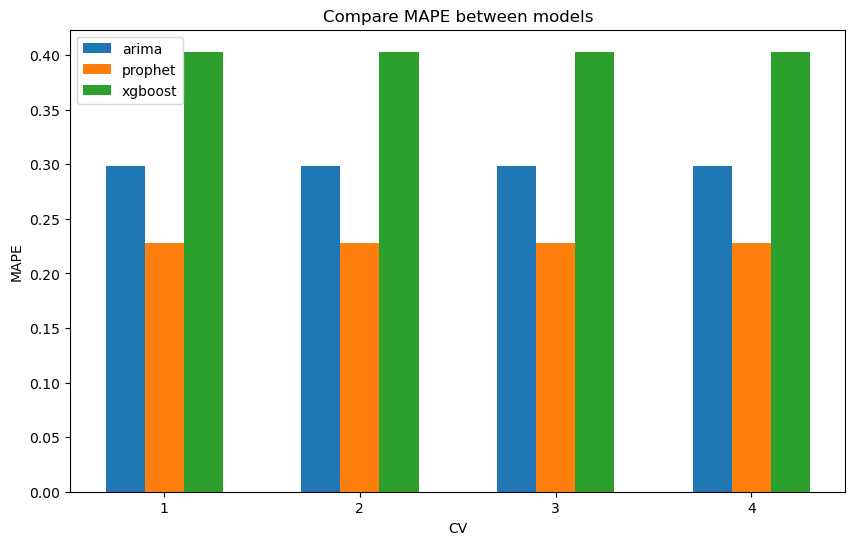

In [ ]:
model_list = {
    "arima": SARIMAXModel,
    "prophet": ProphetModel,
    "xgboost": XGBoostModel,
}

model_perf = {}
for name, model in model_list.items():
    model_perf[name] = []
    for data in data_cv.values():
        if name == "arima":
            result = model(dev_set_meta, exo=False).run_eval(verbose=False)
        else:
            result = model(dev_set_meta).run_eval(verbose=False)

        model_perf[name].append(result)

# Visualize result
#del model_perf["arima"]
models = list(model_perf.keys())
perf = list(model_perf.values())

# Number of data blocks
num_cv = len(perf[0])

# Width of each bar
bar_width = 0.2

# Position of each bar on X-axis
x = range(num_cv)

# Plotting each cluster
plt.figure(figsize=(10,6))
for i, name in enumerate(models):
    plt.bar([pos + i * bar_width for pos in x], perf[i], bar_width, label=name)

# Adding labels and title
plt.xlabel('CV')
plt.ylabel('MAPE')
plt.title('Compare MAPE between models')
plt.xticks([pos + (len(models) - 1) * bar_width / 2 for pos in x], range(1, num_cv + 1))
plt.legend()

# Show plot
plt.show()

# Inference on unseen data, i.e train with all dataset to make the final prediction

In [ ]:
SARIMAX_predictor = SARIMAXModel({"train": prod_set.iloc[:TEST_INDEX, :], "val": prod_set.iloc[TEST_INDEX:, :]})
SARIMAX_predictor.train()
arima_prediction = SARIMAX_predictor.predict()

prophet_predictor = ProphetModel({"train": prod_set.iloc[:TEST_INDEX, :], "val": prod_set.iloc[TEST_INDEX:, :]})
prophet_predictor.train()
prophet_prediction = prophet_predictor.predict()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2231.860, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2225.123, Time=1.36 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=2226.599, Time=1.39 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2233.248, Time=0.38 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2227.437, Time=0.39 sec


KeyboardInterrupt: 

Our ARIMA prediction: [237.67712542069546, 241.36709222159354, 406.81184784232914, 168.0281350968042, 277.90561014185977, 451.32472230402095, 426.63936005758904, 236.00306043120537, 264.5481350606441, 222.8371736631044, 109.70363464680644, 228.11117151542686, 58.75739647188569, 319.2684759309836, 478.7761699496777, 312.50172735310133, 303.7414858984322, 407.2883003381883]
Our Prophet prediction: [317.00165230745574, 304.8576380584733, 447.5751567920493, 367.0769499270065, 328.0612717731203, 289.4606512370002, 317.25693896372985, 254.46110775802495, 257.91224576111875, 257.4450358649487, 253.62854134973577, 253.11333074974914, 319.66616549209573, 307.14543148137204, 448.2848871605558, 372.61437528411295, 331.2053157832317, 291.33127182015585]


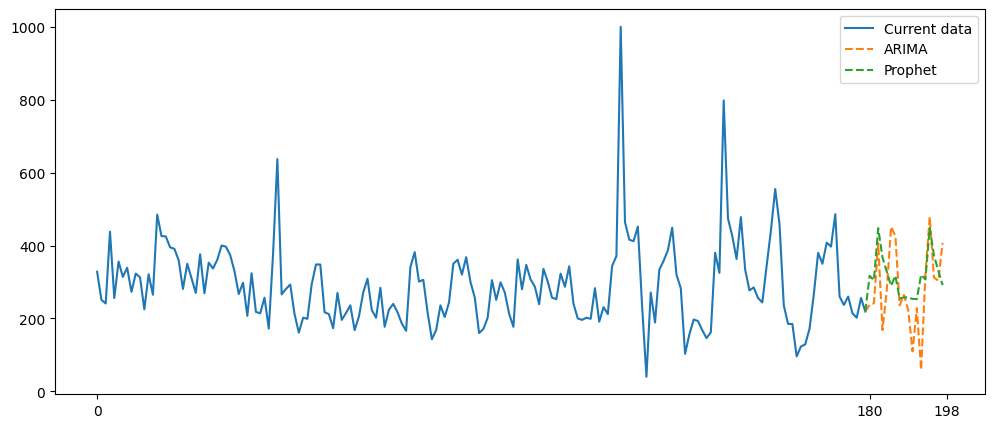

In [ ]:
plt.figure(figsize=(12,5))
current_demand = dev_set.loc[:, TARGET_COL_NAME].tolist()
plt.plot(range(TEST_INDEX), current_demand, label="Current data")

print("Our ARIMA prediction:", arima_prediction.to_list())
plt.plot(range(TEST_INDEX-1, TEST_INDEX+TEST_PERIOD), [current_demand[-1]] + arima_prediction.tolist(), linestyle="--", label="ARIMA")

print("Our Prophet prediction:", prophet_prediction.to_list())
plt.plot(range(TEST_INDEX-1, TEST_INDEX+TEST_PERIOD), [current_demand[-1]] + prophet_prediction.tolist(), linestyle="--", label="Prophet")

plt.xticks([0, TEST_INDEX, TEST_INDEX+TEST_PERIOD])
plt.legend()
plt.show()

In [ ]:
# num_cols = 4
# num_rows = 5

# plt.figure(figsize=(20, 10))
# for i, col in enumerate(missing_data_summary.index):
#     plt.subplot(num_rows, num_cols, i + 1)
#     sns.histplot(tiny_data[col], color="lightblue") # drop na values only when visualize

#     mean_val = tiny_data[col].mean()
#     median_val = tiny_data[col].median()
    
#     # Add vertical lines for mean and median
#     plt.axvline(x=mean_val, color='red', linestyle='--', linewidth=3, label='Mean')
#     plt.axvline(x=median_val, color='black', linestyle='--', linewidth=3, alpha=.7, label='Median')

#     plt.xlabel("")
#     plt.title(col + f" ({int(missing_data_summary.loc[col, 'missing_per'])}% NA)", fontsize=10)

# plt.tight_layout()
# plt.suptitle("Distrubtion plot of variable", fontsize=16)
# plt.subplots_adjust(top=0.9)
# plt.legend()
# plt.show()

In [ ]:
# num_cols = 4
# num_rows = 5

# plt.figure(figsize=(20, 10))
# for i, col in enumerate(missing_data_summary.index):
#     plt.subplot(num_rows, num_cols, i + 1)
#     sns.lineplot(tiny_data[col], color="lightblue") # drop na values only when visualize

#     mean_val = tiny_data[col].mean()
#     median_val = tiny_data[col].median()
    
#     # Vertical line for missing position
#     missing_indices = tiny_data[col][tiny_data[col].isnull()].index
#     plt.axvline(x=missing_indices[0], color='green', linestyle=':', linewidth=0.7, label="Missing")
#     for missing_index in missing_indices[1:]:
#         plt.axvline(x=missing_index, color='green', linestyle=':', linewidth=0.7)  

#     # Add vertical lines for mean and median
#     plt.axhline(y=mean_val, color='red', linestyle='--', linewidth=3, label='Mean')
#     plt.axhline(y=median_val, color='black', linestyle='--', linewidth=3, alpha=.7, label='Median')

#     plt.ylabel("")
#     plt.title(col + f" ({int(missing_data_summary.loc[col, 'missing_per'])}% NA)", fontsize=10)

# plt.tight_layout()
# plt.suptitle("Time series plot of variable", fontsize=16)
# plt.subplots_adjust(top=0.9)
# plt.legend(loc='lower right', bbox_to_anchor=(2, 0), ncol=1)
# plt.show()

### Check for autocorrelation

In [ ]:
# from matplotlib import pyplot
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plot_acf(target.diff(12).dropna(), lags=50)
# plot_pacf(target.diff(12).dropna(), lags=50)
# pyplot.show()

# from statsmodels.tsa.stattools import adfuller
# from numpy import log
# result = adfuller(target.dropna())
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])

In [ ]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# result = seasonal_decompose(target.dropna(), model='additive', period=12)
# plt.figure(figsize=(20,6))
# result.plot()
# plt.show()

In [ ]:
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=4, gap=6, test_size=18)

non_na_data = tiny_data.dropna()
X_in = non_na_data.drop("sales_actuals_monthly__orderintake", axis=1)
y = non_na_data["sales_actuals_monthly__orderintake"]

importances_mean = []
importances_std = []
for i, (train_index, test_index) in enumerate(tscv.split(X_in, y)):
    print(train_index, test_index)
    X_train, y_train = X_in.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X_in.iloc[test_index], y.iloc[test_index]
    model = XGBRegressor().fit(X_train, y_train)
    result = permutation_importance(
        model,
        X_val,
        y_val,
        n_repeats=10,
        scoring='neg_mean_absolute_error', # neg_mean_absolute_percentage_error
        random_state=0
    )

    importances_mean.append(result.importances_mean)
    importances_std.append(result.importances_std)

In [ ]:
feature_importance_df = pd.Series(np.mean(importances_mean, axis=0), index=X_in.columns).sort_values(ascending=True)
feature_importance_df.plot.barh()
plt.title("Permutation importance (the larger the better)")
plt.xlabel("Decrease in MAE score")
plt.plot()

In [ ]:
vehicle_group_list = [f'{i:02}' for i in range(1, 65)]
country_list = [f'Country {name}' for name in ['A', 'B', 'C', 'D']]
print(vehicle_group_list)
print(country_list)

In [ ]:
in_correlation = X_in.corrwith(y)
print(in_correlation[abs(in_correlation) > 0.39])
colors = ['red' if abs(val) > 0.39 else 'grey' for val in in_correlation]
ax = in_correlation.plot.barh(color=colors)
ax.axvline(x=0.39, color='black', linestyle='dotted')
ax.set_xticks([0.39])
yticks = ax.get_yticklabels()
ytick_labels = [label.get_text().replace("__vehiclegroup01__", "_") for label in yticks]
ax.set_yticklabels(ytick_labels)
plt.show()

## External features

In [ ]:
# X_ex = external_data.iloc[non_na_data.index,:].drop(columns=['month'])

# importances_mean = []
# importances_std = []
# for i, (train_index, test_index) in enumerate(tscv.split(X_ex, y)):
#     print(train_index, test_index)
#     X_train, y_train = X_ex.iloc[train_index], y.iloc[train_index]
#     X_val, y_val = X_ex.iloc[test_index], y.iloc[test_index]
#     model = XGBRegressor().fit(X_train, y_train)
#     result = permutation_importance(
#         model,
#         X_val,
#         y_val,
#         n_repeats=10,
#         scoring='neg_mean_absolute_error', # neg_mean_absolute_percentage_error
#         random_state=0
#     )

#     importances_mean.append(result.importances_mean)
#     importances_std.append(result.importances_std)

# feature_importance_df = pd.Series(np.mean(importances_mean, axis=0), index=X_ex.columns).sort_values(ascending=True)[:20]
# feature_importance_df.plot.barh()
# plt.title("Permutation importance (the larger the better)")
# plt.xlabel("Decrease in MAE score")
# plt.plot()

In [ ]:
# ex_correlation = X_ex.corrwith(y)
# plt.figure(figsize=(15, 6))
# ex_correlation.plot.box(vert=False)
# plt.show()

The middle 50% of the data (interquartile range) has value smaller quite small. We visualize only features with correlation larger than +-0.4

In [ ]:
# large_corr_ex_features = ex_correlation[abs(ex_correlation) > 0.4]
# print(large_corr_ex_features)

In [ ]:
# plt.barh(large_corr_ex_features.index, large_corr_ex_features.values)
# plt.show()

## Visualize number of features for each vehicle group

In [ ]:
# vec_dict = {}
# for veh in vehicle_group_list:
#     vec_dict[veh] = len(internal_data.filter(regex=f"vehiclegroup{veh}").columns)

# df_temp = pd.DataFrame(vec_dict.items(), columns=['Vehicle group', 'No. of features'])

# plt.figure(figsize=(14, 7), facecolor='white')
# colors = ['red' if i in [49, 52, 55] else 'grey' for i in range(1, len(df_temp)+1)]
# colors[:6] = ["lightblue"] * 6
# plt.bar(df_temp['Vehicle group'], df_temp['No. of features'], color=colors, edgecolor='none')
# plt.axhline(y=5, xmax=0.82, color='black', linestyle='dotted')

# plt.xlabel('Vehicle group', fontsize=15)
# plt.ylabel('No. of features', fontsize=15)
# plt.title('Number of features for each vehicle group', fontsize=25)
# plt.xticks(["01", "06"] + ["49", "52", "55"], fontsize=10)
# plt.yticks([5,15,18], fontsize=15)
# plt.tight_layout()
# plt.box(False)
# plt.savefig("../img/vehicle_vs_internal_features.png", bbox_inches='tight')
# plt.show()